In [1]:
import os
import numpy as np 
import torch
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import pandas as pd 
from PIL import Image
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor







In [2]:
imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

In [3]:

def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    box_list = [xmin, ymin, xmax, ymax]
    return box_list

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as fold:
        raw_data = fold.read()
        soup = BeautifulSoup(raw_data, 'xml')
        objects = soup.find_all('object')
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [4]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split

class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
        self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/kaggle/input/face-mask-detection/images/", file_image)
        label_path = os.path.join("/kaggle/input/face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

def collate_fn(batch):
    return tuple(zip(*batch))



full_dataset = MaskDataset(data_transform)


train_split = 0.8
val_split = 0.1
test_split = 0.1

data_len = len(full_dataset)
train_size = int(train_split * data_len)
val_size = int(val_split * data_len)
test_size = data_len - (train_size + val_size)

rem_size = data_len - train_size

train_dataset, left_data = torch.utils.data.random_split(full_dataset, [train_size, rem_size])
val_dataset, test_dataset = torch.utils.data.random_split(left_data, [val_size, test_size])


print("Non-GPU Data Loaders created")



Non-GPU Data Loaders created


In [5]:
if torch.cuda.is_available():
    print("GPU Available")
else:
    print("Running on CPU")

GPU Available


In [6]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [7]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 40
model.to(device)

batch_size = 16

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    

params_list = []
for param in model.parameters():
    if param.requires_grad:
        params_list.append(param)

# optimizer = torch.optim.SGD(params_list, lr=0.005, momentum=0.9, weight_decay=0.0005)

optimizer = torch.optim.Adam(params_list, lr=0.005, weight_decay=0.0005)

len_dataloader = len(train_data_loader)

epoch_loss_list = []  
class_loss_list = []
box_loss_list = []


for epoch in range(num_epochs):
    print("Epoch number is ......... {}" .format(epoch))
    model.train() 
    epoch_loss = 0
    class_loss = 0
    box_loss = 0
    for imgs, annotations in train_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        
        epoch_loss += losses.item()  # Convert the tensor to a scalar and add to the epoch_loss
        class_loss += loss_dict['loss_classifier'].item()
        box_loss += loss_dict['loss_box_reg'].item()
        
    print("Loss for Epoch {} is : {} " .format(epoch, epoch_loss))
    epoch_loss /= len_dataloader  # Calculate the average loss per epoch
    class_loss /= len_dataloader
    box_loss /= len_dataloader
    epoch_loss_list.append(epoch_loss)
    class_loss_list.append(class_loss)
    box_loss_list.append(box_loss)


Epoch number is ......... 0


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Loss for Epoch 0 is : 2451155931292250.5 
Epoch number is ......... 1
Loss for Epoch 1 is : 108337601.59765625 
Epoch number is ......... 2
Loss for Epoch 2 is : 1553613971.5703125 
Epoch number is ......... 3
Loss for Epoch 3 is : 712549175958.4375 
Epoch number is ......... 4
Loss for Epoch 4 is : 81619255928.22656 
Epoch number is ......... 5
Loss for Epoch 5 is : 443099084049.4375 
Epoch number is ......... 6
Loss for Epoch 6 is : 343155319575.15625 
Epoch number is ......... 7
Loss for Epoch 7 is : 524468389820.25 
Epoch number is ......... 8
Loss for Epoch 8 is : 625091629590.5 
Epoch number is ......... 9
Loss for Epoch 9 is : 136229096165.125 
Epoch number is ......... 10
Loss for Epoch 10 is : 168935906764.07812 
Epoch number is ......... 11
Loss for Epoch 11 is : 31250261571.8125 
Epoch number is ......... 12
Loss for Epoch 12 is : 413017553163.0 
Epoch number is ......... 13
Loss for Epoch 13 is : 4466479313.125 
Epoch number is ......... 14
Loss for Epoch 14 is : 1259431587

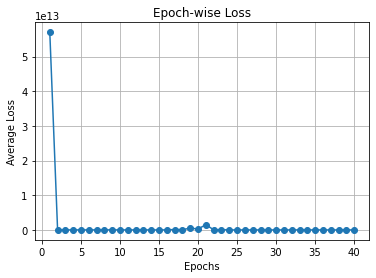

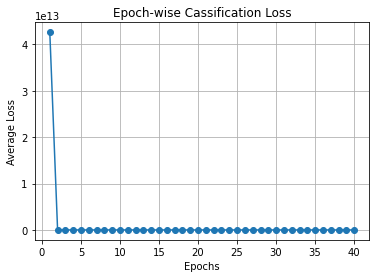

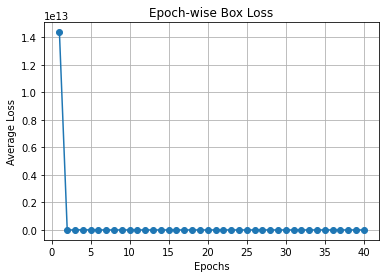

In [9]:
# Plot the epoch-wise loss
plt.plot(range(1, num_epochs + 1), epoch_loss_list, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Epoch-wise Loss')
plt.grid()
plt.show()

# Plot the epoch-wise Classification loss
plt.plot(range(1, num_epochs + 1), class_loss_list, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Epoch-wise Cassification Loss')
plt.grid()
plt.show()

# Plot the epoch-wise Box loss
plt.plot(range(1, num_epochs + 1), box_loss_list, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Epoch-wise Box Loss')
plt.grid()
plt.show()

In [10]:
for imgs, annotations in train_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [11]:
model.eval()
preds = model(imgs)
preds

RuntimeError: CUDA out of memory. Tried to allocate 442.00 MiB (GPU 0; 15.90 GiB total capacity; 14.76 GiB already allocated; 29.75 MiB free; 15.23 GiB reserved in total by PyTorch)

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [ ]:
print("Prediction")
plot_image(imgs[0], preds[0])
print("Target")
plot_image(imgs[0], annotations[0])